## **Procesamiento de Datos**

In [119]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Procesamiento de datos
from sklearn.preprocessing import LabelEncoder

# Modelo para averiguar que columnas son mejores para nuestro modelo
from sklearn.ensemble import ExtraTreesClassifier

# Separar train, test
from sklearn.model_selection import train_test_split

# Modelo
from sklearn.impute import KNNImputer

# Métricas
from sklearn.metrics import f1_score

In [131]:
df1 = pd.read_csv("../Data/titanic 1.csv")
df2 = pd.read_csv("../Data/titanic 2.csv")
df = pd.merge(df1, df2, on = "PassengerId")

In [121]:
df.head(5)

,PassengerId,Name,Sex,Age,Survived,Pclass,Ticket,Fare
0,1,"Braund, Mr. Owen Harris",male,22.0,0,3,A/5 21171,7.2500
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,1,PC 17599,71.2833
2,3,"Heikkinen, Miss. Laina",female,26.0,1,3,STON/O2. 3101282,7.9250
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,1,113803,53.1000
4,5,"Allen, Mr. William Henry",male,35.0,0,3,373450,8.0500


**Es importante saber con cuantos elementos (filas) y atributos (columnas) estámos trabajando, además de conocer sus tipos de datos y su información estadística, y si fuese necesario, cambiar el tipo de dato de las columnas.**

In [122]:
# .shape nos da el número de filas y columnas
df.shape

(891, 8)

In [132]:
# Cambiar tipo de datos
df.PassengerId = df.PassengerId.astype("category")
df.Pclass = df.Pclass.astype("category")

In [124]:
# .describe() nos da un DataFrame con la información estadística de las columnas
df.describe()

,Age,Survived,Fare
count,714.000000,891.000000,891.000000
mean,29.699118,0.383838,32.204208
std,14.526497,0.486592,49.693429
min,0.420000,0.000000,0.000000
25%,20.125000,0.000000,7.910400
50%,28.000000,0.000000,14.454200
75%,38.000000,1.000000,31.000000
max,80.000000,1.000000,512.329200


In [125]:
# .info() nos da el tipo de variables de cada columna y si hay algun valor NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  891 non-null    category
 1   Name         891 non-null    object  
 2   Sex          891 non-null    object  
 3   Age          714 non-null    float64 
 4   Survived     891 non-null    int64   
 5   Pclass       891 non-null    category
 6   Ticket       891 non-null    object  
 7   Fare         891 non-null    float64 
dtypes: category(2), float64(2), int64(1), object(3)
memory usage: 83.9+ KB


In [126]:
# Numero de NaN's
print(df.isnull().sum())
print("-----------------------")
# Porcentaje de NaN's en cada columna
print(df.isnull().sum()/len(df)*100)

PassengerId      0
Name             0
Sex              0
Age            177
Survived         0
Pclass           0
Ticket           0
Fare             0
dtype: int64
-----------------------
PassengerId     0.00000
Name            0.00000
Sex             0.00000
Age            19.86532
Survived        0.00000
Pclass          0.00000
Ticket          0.00000
Fare            0.00000
dtype: float64


### · División entre variables numéricas y categóricas

En esta parte vamos a separar las columnas númericas y las columnas no númericas.

Vamos a tener 2 DataFrames, llamados **`df_num`** y **`df_cat`** respectivamente.

El objetivo de esto es trabajar de una forma más cómoda con el DataFrame, conocer cuales columnas no son númericas y aplicarle funciones correspondientes a cada columna dependiendo de su tipo de dato.

**Al final esta parte, el DataFrame no númerico va a pasar a tener solo columnas no númericas.**

Para trabajar nulos, outliers a nivel de datos de columnas, primero hay que separar los datos de train con los datos de test

In [163]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

print(f"Conjunto de Train: {X_train.shape, y_train.shape}")
print(f"Conjunto de Test: {X_test.shape, y_test.shape}")

Conjunto de Train: ((712, 7), (712,))
Conjunto de Test: ((179, 7), (179,))


In [165]:
# Vamos a unir las x con las y
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [166]:
# df_num
# ._get_numeric_data() filtra el DataFrame y retorna solo las columnas con valores númericos.
# Si tenemos alguna columna con valores númericos pero el tipo de dato no es el correcto la función
# ._get_numeric_data() seguramente falle.

df_num_train = train._get_numeric_data().copy()
df_num_test = test._get_numeric_data().copy()
df_num_train.head(3)

,Age,Fare,Survived
331,45.5,28.500,0
733,23.0,13.000,0
382,32.0,7.925,0


In [167]:
# df_cat
# df_cat sería el DataFrame resultante si quitamos las columnas de df_num

df_cat_train = train.drop(df_num_train.columns, axis = 1)
df_cat_test = test.drop(df_num_test.columns, axis = 1)
df_cat_train.head(3)

,PassengerId,Name,Sex,Pclass,Ticket
331,332,"Partner, Mr. Austen",male,1,113043
733,734,"Berriman, Mr. William John",male,2,28425
382,383,"Tikkanen, Mr. Juho",male,3,STON/O 2. 3101293


### · Imputer

La imputación de datos es la sustitución de valores no informados (NaN's) en una observación por otros.

En general existen 2 técnicas:

1. La primera técnica consiste en rellenar estos valores con la **media** (o **mediana**) de los datos de la variable en el caso de que se trate de una **variable numérica**. Para el caso de las **variables categóricas** imputamos los valores perdidos con la **moda** de la variable o usando la logica si esa variable categorica depende de otra variable.


2. La segunda técnica, que es más avanzada, consiste en el uso de **modelos predictivos** para estimar los valores perdidos. Un modelo no paramétrico muy popular para estos casos es el **k-nearest neighbors (KNN)**, donde se estima el valor perdido como la media (en el caso de las variables numéricas) de los valores de los **k-vecinos u observaciones mas cercanos**. Analogamente, para las **variables categóricas**, se utiliza las **clase mayoritaria de entre los k mas cercanos**.

In [77]:
# Primera técnica:
# Para la imputación de los datos vamos a "llenar" los NaN's por la media de edad
df["Age"].fillna(df["Age"].mean())
# En este ejemplo llena TODOS los NaN's por la misma media.
# NOTA: No se ejecutó in-place

0      22.000000
1      38.000000
2      26.000000
3      35.000000
4      35.000000
         ...    
886    27.000000
887    19.000000
888    29.699118
889    26.000000
890    32.000000
Name: Age, Length: 891, dtype: float64

La librería **missingpy** es una librería más actualizada que scikit-learn para la imputación de valores faltantes. Es una librería más completa y flexible que scikit-learn, y ofrece una mayor variedad de métodos de imputación.

In [168]:
# Segunda técnica:
# Reemplaza los NaN's de la columna "Age" o cualquier columna que tenga nulos por la media de las edades o de la columna que le corresponde de los k-vecinos mas cercanos (KNN).
imputer = KNNImputer(n_neighbors = 3) #inicializa el modelo predictivo
# perfila cada fila y a cada uno que le falta el valor lo rellena con la media de los 3 mas cercanos que se asemejen a el                                
df_num_imp_train = imputer.fit(df_num_train) #entrenamos el modelo y aplicamos las transformaciones al df
df_num_imp_train = imputer.transform(df_num_train)
df_num_imp_test = imputer.transform(df_num_test)
# array 
# El resultado de utilizar el KNNImputer es un array.
# Esto quiere decir que se pierde el formato de DataFrame, por lo tanto perdemos el nombre de las columnas.
# En este ejemplo llena cada NaN's por la media de las edades de los k-vecinos más cercanos.
# Para volver a tener el DataFrame con las columnas volver a definir el objeto.

df_num_train = pd.DataFrame(df_num_imp_train, columns = df_num_train.columns)
df_num_test = pd.DataFrame(df_num_imp_test, columns = df_num_test.columns)
# Ya no hay NaN's en la columna "Age"
df_num_train.isnull().sum()/df_num_train.shape[0]

Age         0.0
Fare        0.0
Survived    0.0
dtype: float64

### · Nuevas variables categoricas

In [169]:
# Separando surname del name y el title del name
df_cat_train["Surname"] = df_cat_train["Name"].apply(lambda x : x.split(",")[0])
df_cat_train["Mr./Mrs."] = df_cat_train["Name"].apply(lambda x : x.split(" ")[1])

df_cat_test["Surname"] = df_cat_test["Name"].apply(lambda x : x.split(",")[0])
df_cat_test["Mr./Mrs."] = df_cat_test["Name"].apply(lambda x : x.split(" ")[1])

In [170]:
# A partir de los apellidos creamos una nueva columna
dict_apellidos = df_cat_train["Surname"].value_counts().to_dict()

# Si el apellido se repite 1 vez lo agrega a la categoria Soltero
# Si el apellido se repite 2 veces lo agrega a la categoria Pareja
# Si el apellido se repite entre 3 y 4 veces lo agrego a la categoria Familia
# Si el apellido se repite mas de 4 veces lo agrego a la categoria Familia Grande

def func_apellidos(dict_apellidos):
    
    for apellido, count in dict_apellidos.items():
        if count == 1:
            dict_apellidos[apellido] = "Soltero"
        elif count == 2:
            dict_apellidos[apellido] = "Matrimonio"
        elif count < 5:
            dict_apellidos[apellido] = "Familia"
        else:
            dict_apellidos[apellido] = "Familia Grande"
            
    return dict_apellidos
            
dict_apellidos = func_apellidos(dict_apellidos)

df_cat_train["Family"] = df_cat_train["Surname"].map(dict_apellidos)
df_cat_test["Family"] = df_cat_test["Surname"].map(dict_apellidos)

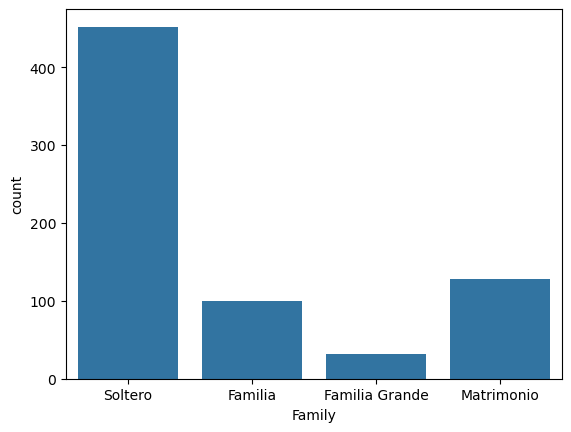

In [171]:
# Veamos la distribución de la nueva columna
sns.countplot(x = df_cat_train["Family"])
plt.show()

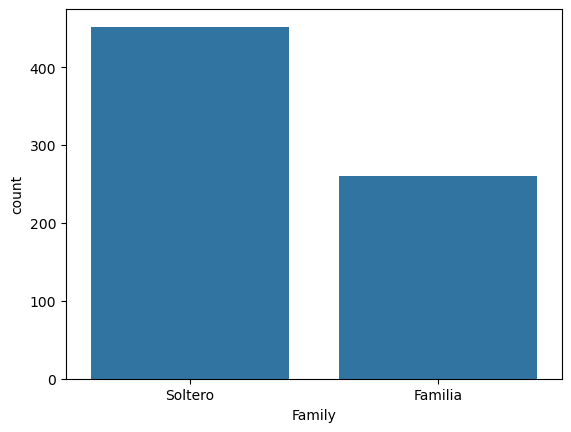

In [172]:
# La categoria de Soltero es muy grande (existe un desbalance), vamos a unir las otras 3 categorias para poder nivelarlo
# Nota: Podemos hacer cualquier cosa que se nos ocurra, esto es una posibilidad de todo lo que podemos hacer.
df_cat_train["Family"] = df_cat_train["Family"].replace({"Matrimonio" : "Familia", "Familia Grande" : "Familia"})
df_cat_test["Family"] = df_cat_test["Family"].replace({"Matrimonio" : "Familia", "Familia Grande" : "Familia"})
sns.countplot(x = df_cat_train["Family"])
plt.show()

In [173]:
# Vamos a crear otra categoria a partir del Mr. y Mrs.
dict_mr = df_cat_train["Mr./Mrs."].value_counts().to_dict()

# Definimos una función que clasifique según el valor de cada fila.

def func_mr(dict_mr):
    
    for mr, count in dict_mr.items():
        if mr == "Mr.":
            dict_mr[mr] = "Mr."
            
        elif mr == "Mrs.":
            dict_mr[mr] = "Mrs."
            
        elif mr == "Miss.":
            dict_mr[mr] = "Miss."
            
        else:
            dict_mr[mr] = "Other"
            
    return dict_mr
            
dict_mr = func_mr(dict_mr)

df_cat_train["Title"] = df_cat_train["Mr./Mrs."].map(dict_mr)
df_cat_test["Title"] = df_cat_test["Mr./Mrs."].map(dict_mr)

df_cat_train.drop("Mr./Mrs.", axis = 1, inplace = True)
df_cat_test.drop("Mr./Mrs.", axis = 1, inplace = True)

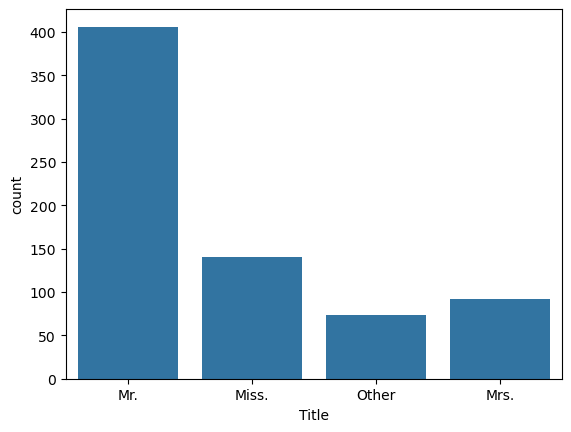

In [174]:
sns.countplot(x = df_cat_train["Title"])
plt.show()

In [ ]:
# Esta vez voy a decidir no unir las categorias, si vemos los datos de la columna "Sex"
# podemos ver que hay mas hombres que mujeres, por lo que si unimos las 3 categorias menores 
# vamos a quedar practicamente con la misma informacion que la columna "Sex"

### **CODIFICACION DE VALORES CATEGORICOS**

### Sex, Familia, Title

Ya tenemos la información limpia de estas 3 columnas, ahora debemos transformar estas columnas a numéricas.

Para esto existen 2 funciones:
1. **pd.get_dummies()**: esta función va a generar una columna por cada elemento único en una columna y, dependiendo del valor, va a colocar 1 en la columna correspondiente y 0 en las otras. Esté método resulta de utilidad cuando la categoria no sigue un orden en particular.


2. **sklearn.preprocessing.LabelEncoder()**: esta función transforma toda la columna a números enteros, si la columna tiene n elementos únicos, va a cambiar esos elementos por lo números desde el **`0 hasta n - 1`**. Éste método resulta de utilidad si la categoria sigue cierto orden.

In [175]:
# Para unir estas nuevas columnas a df_cat podemos hacer un pd.concat()
df_cat_train = pd.concat([df_cat_train, pd.get_dummies(data = df_cat_train["Sex"])], axis = 1)
df_cat_test = pd.concat([df_cat_test, pd.get_dummies(data = df_cat_test["Sex"])], axis = 1)
# Y ahora podemos eliminar la columna "Sex"
df_cat_train.drop("Sex", axis = 1, inplace = True)
df_cat_test.drop("Sex", axis = 1, inplace = True)

In [176]:
# Vamos a repetir la operación con las columnas "Family" y "Title"
for col in ["Family", "Title", "Pclass"]:
    
    df_cat_train = pd.concat([df_cat_train, pd.get_dummies(data = df_cat_train[col])], axis = 1)
    df_cat_test = pd.concat([df_cat_test, pd.get_dummies(data = df_cat_test[col])], axis = 1)

    df_cat_train.drop(col, axis = 1, inplace = True)
    df_cat_test.drop(col, axis = 1, inplace = True)

In [177]:
# Ahora voy a hacer drop de las columnas "Name", "Surname" y "Ticket"
# De la columna "Name" sacamos "Surname" y luego "Family", por lo que es información redundate
# Y de la columna "Ticket" podemos sacar información similar a la que sacamos con la columna "Surname"
df_cat_train.drop(["Name", "Surname", "Ticket", "PassengerId"], axis = 1, inplace = True)
df_cat_test.drop(["Name", "Surname", "Ticket", "PassengerId"], axis = 1, inplace = True)
# La columna Pclass es categorica y numerica, por lo que la vamos a dejar tal cual está
# La columna Survived es la columna que queremos predecir

### **Binning**
Binning es un proceso de transformación de variables numéricas continuas en "contenedores" categóricos discretos, para análisis agrupados.

In [178]:
# Vamos a aplicar Binning a la columna Fare, bins = 5, creamos la division
bins = np.linspace(min(df_num_train["Fare"]), max(df_num_train["Fare"]), 5)

In [179]:
categorias = ["Low_cost", "Turista", "Business", "VIP"]

In [180]:
df_num_train["Fare-Binning"] = pd.cut(df_num_train["Fare"], bins, labels = categorias, include_lowest = True)
df_num_test["Fare-Binning"] = pd.cut(df_num_test["Fare"], bins, labels = categorias, include_lowest = True)

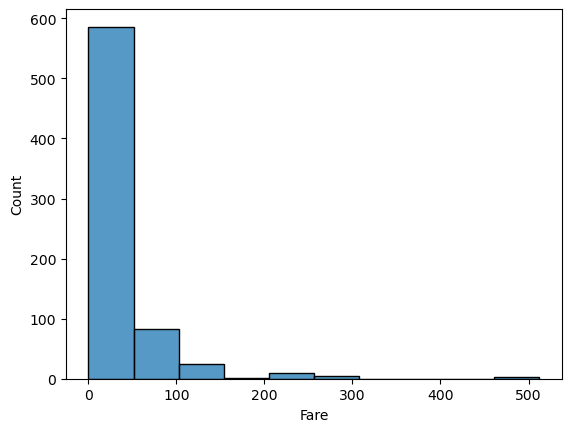

In [181]:
sns.histplot(df_num_train["Fare"], bins = 10)
plt.show()

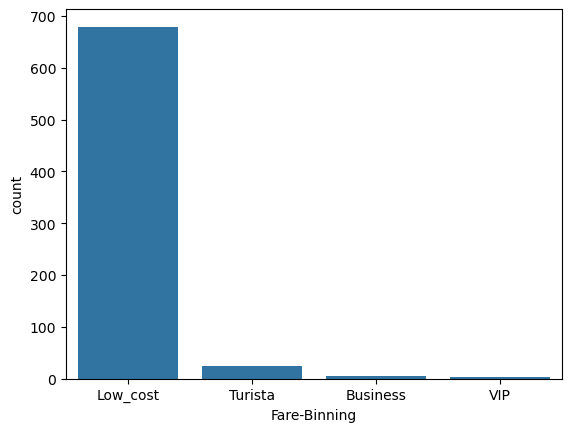

In [182]:
sns.countplot(x = df_num_train["Fare-Binning"])
plt.show()

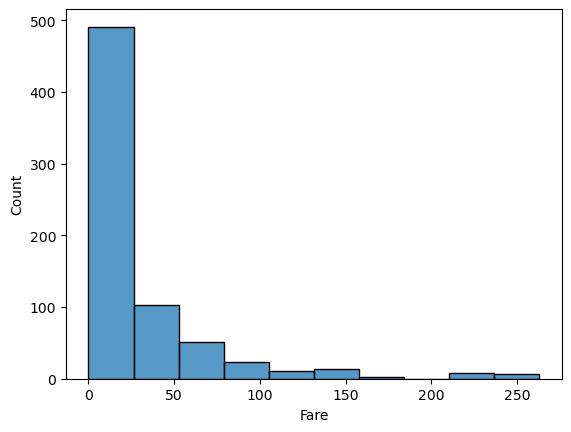

In [183]:
# Vemos que el binning se ve afectado por los outliers de esta columna
# Vamos a eliminarlos
df_num_train = df_num_train[df_num_train["Fare"] < 400]

sns.histplot(df_num_train["Fare"], bins = 10)
plt.show()

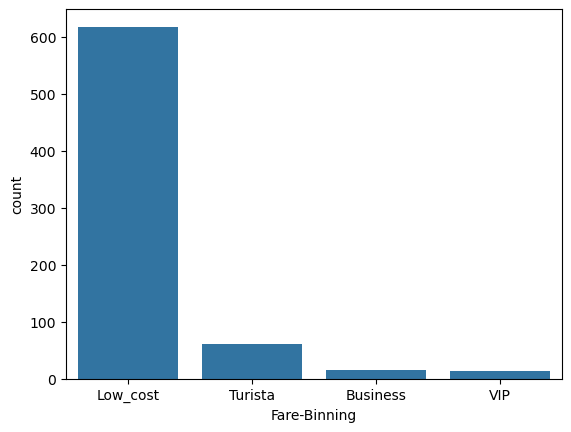

In [184]:
# Aplicamos otra vez Binning
bins = np.linspace(min(df_num_train["Fare"]), max(df_num_train["Fare"]), 5)
categorias = categorias
df_num_train["Fare-Binning"] = pd.cut(df_num_train["Fare"], bins, labels = categorias, include_lowest = True)
df_num_test["Fare-Binning"] = pd.cut(df_num_test["Fare"], bins, labels = categorias, include_lowest = True)
sns.countplot(x = df_num_train["Fare-Binning"])
plt.show()

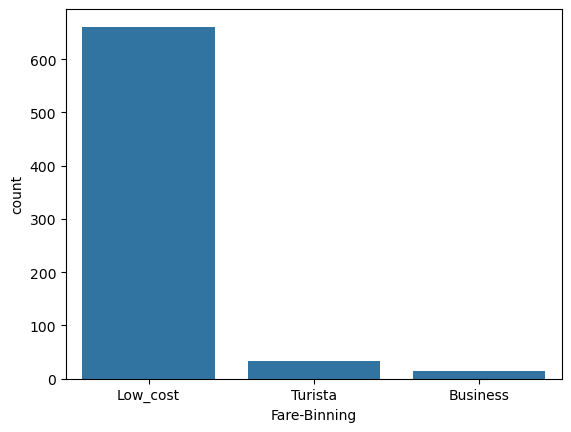

In [185]:
# Existe un desbalance muy grande aún problema para el modelo
# Vamos a hacer 3 grupos en lugar de 4
bins = np.linspace(min(df_num_train["Fare"]), max(df_num_train["Fare"]), 4)
categorias = categorias[0:3]
df_num_train["Fare-Binning"] = pd.cut(df_num_train["Fare"], bins, labels = categorias, include_lowest = True)
df_num_test["Fare-Binning"] = pd.cut(df_num_test["Fare"], bins, labels = categorias, include_lowest = True)

sns.countplot(x = df_num_train["Fare-Binning"])
plt.show()

Deberiamos hacer undersipling o oversimpling. Aun existe un desbalance importante. Por ahora dejemos esta columna como está y luego veremos si es de importancia

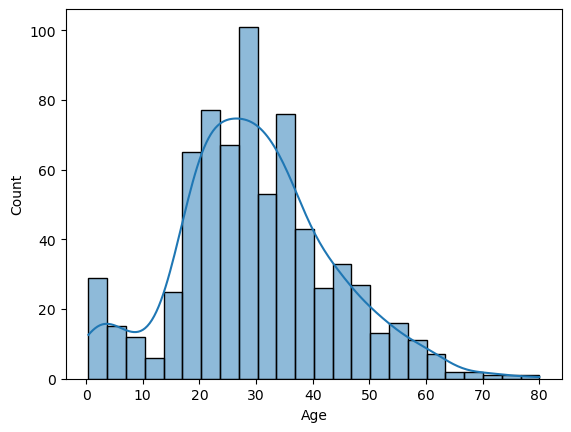

In [186]:
sns.histplot(df_num_train["Age"], kde= True)
plt.show()

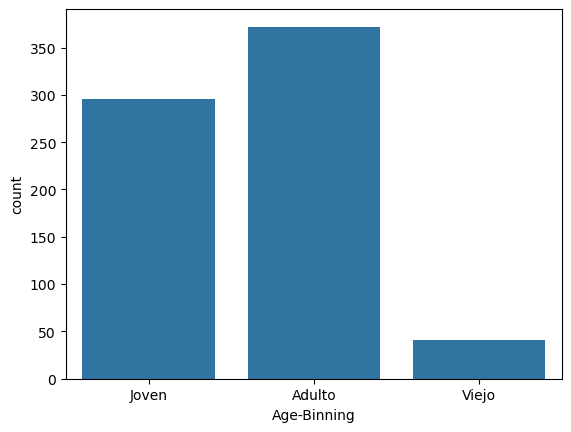

In [187]:
# Vamos a hacer Binning con bins = 3
bins = np.linspace(min(df_num_train["Age"]), max(df_num_train["Age"]), 4)
categorias = ["Joven", "Adulto", "Viejo"]
df_num_train["Age-Binning"] = pd.cut(df_num_train["Age"], bins, labels = categorias, include_lowest = True)
df_num_test["Age-Binning"] = pd.cut(df_num_test["Age"], bins, labels = categorias, include_lowest = True)

sns.countplot(x = df_num_train["Age-Binning"])
plt.show()

In [188]:
# Vamos a dejarlo así, y vamos a convertir esta columna a numerica con LabelEncoder

# Inicializamos un objeto LabelEncoder()
age_labelEncoding = LabelEncoder()
# Lo "entrenamos" con los datos de la columna
age_labelEncoding.fit(df_num_train["Age-Binning"].values)
# Transformamos la columna
age_train = age_labelEncoding.transform(df_num_train["Age-Binning"].values)
age_test = age_labelEncoding.transform(df_num_test["Age-Binning"].values)
# El resultado es la columna cambiada a numeros.
df_num_train["Age-Binning"] = age_train
df_num_test["Age-Binning"] = age_test

In [189]:
# Vamos a hacer lo mismo con "Fare-Binning"
# Inicializamos un objeto LabelEncoder()
fare_labelEncoding = LabelEncoder()
# Lo "entrenamos" con los datos de la columna
fare_labelEncoding.fit(df_num_train["Fare-Binning"].values)
# Transformamos la columna
fare_train = fare_labelEncoding.transform(df_num_train["Fare-Binning"].values)
fare_test = fare_labelEncoding.transform(df_num_test["Fare-Binning"].values)
# El resultado es la columna cambiada a numeros.
df_num_train["Fare-Binning"] = fare_train
df_num_test["Fare-Binning"] = fare_test

### **Feature Selection**

In [190]:
# Vamos a unir df_num y df_cat
X_train = pd.concat([df_num_train, df_cat_train], axis = 1)
X_test = pd.concat([df_num_test, df_cat_test], axis = 1)
# NOTA: Como eliminamos filas de df_num y no eliminamos filas de df_cat, el DataFrame tendrá NaN's
# Podemos hacer una imputación de los datos, pero par este ejemplo vamos a eliminar esas filas
X_train.dropna(inplace = True)
X_test.dropna(inplace = True)

# Ahora vamos a separar la columna "objetivo" del resto de columnas
y_train = X_train["Survived"].copy()
y_test = X_test["Survived"].copy()
# Como ya tenemos la columna "objetivo" en otra variable vamos a eliminarla del DataFrame original
X_train.drop("Survived", axis = 1, inplace = True)
X_test.drop("Survived", axis = 1, inplace = True)

In [191]:
X_train.head(5)

,Age,Fare,Fare-Binning,Age-Binning,female,male,Familia,Soltero,Miss.,Mr.,Mrs.,Other,1,2,3
0,45.5,28.5000,1.0,0.0,False,True,False,True,False,True,False,False,False,False,True
1,23.0,13.0000,1.0,1.0,True,False,False,True,False,False,True,False,True,False,False
2,32.0,7.9250,1.0,0.0,True,False,False,True,True,False,False,False,False,False,True
3,26.0,7.8542,1.0,1.0,True,False,False,True,False,False,True,False,True,False,False
4,6.0,31.2750,1.0,1.0,False,True,True,False,False,True,False,False,False,False,True


In [194]:
X_train.corr()

,Fare-Binning,Age-Binning,gender,Familia,Soltero,Miss.,Mr.,Mrs.,Other,1,2,3
Fare-Binning,1.000000,-0.067359,0.001292,-0.016610,0.016610,-0.006186,0.039869,-0.007856,-0.049768,-0.026465,-0.075517,0.084507
Age-Binning,-0.067359,1.000000,-0.033975,-0.061956,0.061956,-0.026724,0.047427,-0.024260,-0.015468,-0.058364,0.009808,0.041654
gender,0.001292,-0.033975,1.000000,0.164781,-0.164781,0.702512,-0.849257,0.506057,-0.115819,0.070253,0.060435,-0.109420
Familia,-0.016610,-0.061956,0.164781,1.000000,-1.000000,0.040973,-0.229186,0.185676,0.121076,-0.039128,0.047951,-0.006029
Soltero,0.016610,0.061956,-0.164781,-1.000000,1.000000,-0.040973,0.229186,-0.185676,-0.121076,0.039128,-0.047951,0.006029
Miss.,-0.006186,-0.026724,0.702512,0.040973,-0.040973,1.000000,-0.596614,-0.196312,-0.169702,0.007453,-0.015712,0.006547
Mr.,0.039869,0.047427,-0.849257,-0.229186,0.229186,-0.596614,1.000000,-0.429772,-0.371517,-0.073946,-0.082318,0.130523
Mrs.,-0.007856,-0.024260,0.506057,0.185676,-0.185676,-0.196312,-0.429772,1.000000,-0.122245,0.058986,0.121958,-0.150312
Other,-0.049768,-0.015468,-0.115819,0.121076,-0.121076,-0.169702,-0.371517,-0.122245,1.000000,0.048145,0.024014,-0.060706
1,-0.026465,-0.058364,0.070253,-0.039128,0.039128,0.007453,-0.073946,0.058986,0.048145,1.000000,-0.285200,-0.617548


In [193]:
X_train = X_train.drop("Age", axis = 1)
X_train = X_train.drop("Fare", axis = 1)
X_train = X_train.drop("male", axis = 1)
X_train.rename(columns = {"female": "gender"}, inplace = True)

X_test = X_test.drop("Age", axis = 1)
X_test = X_test.drop("Fare", axis = 1)
X_test = X_test.drop("male", axis = 1)
X_test.rename(columns = {"female": "gender"}, inplace = True)

In [195]:
# Ya tenemos el feature selection hecho

### **Modelo para saber que variables son las mejores para predecir si alguien sobrevive o no**

In [198]:
# Convertir los nombres de las columnas en strings:
X_train.columns = X_train.columns.astype(str)

In [200]:
X_train.columns

Index(['Fare-Binning', 'Age-Binning', 'gender', 'Familia', 'Soltero', 'Miss.',
       'Mr.', 'Mrs.', 'Other', '1', '2', '3'],
      dtype='object')

In [201]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators = 250,
                              random_state = 0)

forest.fit(X_train, y_train)

ExtraTreesClassifier(n_estimators=250, random_state=0)

In [205]:
X_test.columns = X_test.columns.astype(str)

In [207]:
# Predicción
pred = forest.predict(X_test)

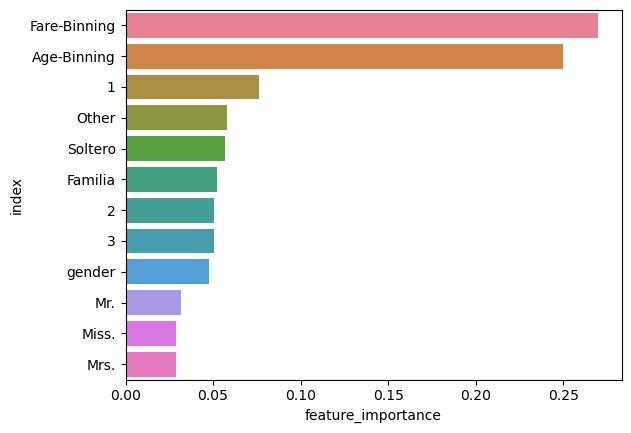

In [211]:
importances = pd.DataFrame(dict(zip(X_train.columns,forest.feature_importances_)), index=[0]).T
importances.columns = ['feature_importance']

std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis = 0)
importances['Error'] = std

importances.sort_values('feature_importance', ascending=False, inplace=True)
importances.reset_index(inplace=True)

sns.barplot(data=importances, y='index', x='feature_importance', hue="index")
plt.show()

In [212]:
f1_score(y_test, pred)

0.37499999999999994

In [213]:
# Ahora vamos a probar sin las columnas Mr, Miss, Mrs
forest = ExtraTreesClassifier(n_estimators = 250,
                              random_state = 0)

forest.fit(X_train.drop(["Mr.", "Miss.", "Mrs."], axis = 1), y_train)

pred = forest.predict(X_test.drop(["Mr.", "Miss.", "Mrs."], axis = 1))

f1_score(y_test, pred)

0.37499999999999994

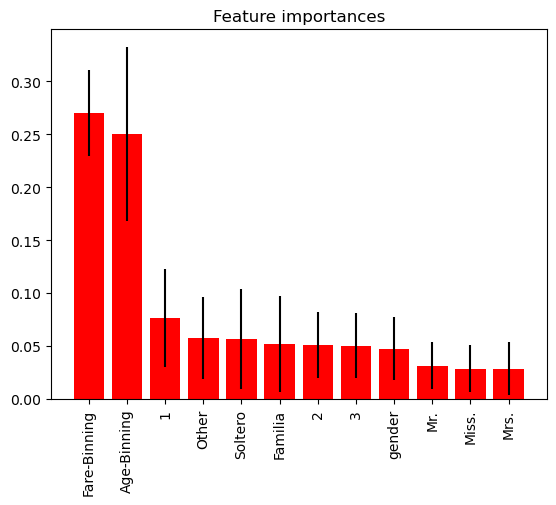

In [216]:
# Crear la gráfica con Matplotlib
plt.figure()

plt.title("Feature importances")

# Utilizar bar para crear las barras y yerr para las barras de error
plt.bar(range(importances.shape[0]), importances['feature_importance'], color="r", yerr=importances['Error'], align="center")

plt.xticks(range(importances.shape[0]), importances['index'], rotation=90)
plt.xlim([-1, importances.shape[0]])
plt.show()


In [220]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators = 250,
                              random_state = 0)

forest.fit(X_train.drop(["Age-Binning"], axis=1), y_train)
pred = forest.predict(X_test.drop(["Age-Binning"], axis = 1))

f1_score(y_test, pred)

0.39999999999999997

In [ ]:
################################################################################################################################